In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all='ignore')

cars_LinearRegression = pd.read_parquet("cars_ready_LinearRegression_small.parquet")
print("Price" in cars_LinearRegression.columns)
print(cars_LinearRegression.columns.tolist())

cars_DecisionTree = pd.read_parquet("cars_ready_DecisionTree_small.parquet")
print("Price" in cars_DecisionTree.columns)
print(cars_DecisionTree.columns.tolist())

cars_BART = pd.read_parquet("cars_ready_BART.parquet")
print("Price" in cars_BART.columns)
print(cars_BART.columns.tolist())

False
['Mileage', 'Log_Mileage', 'Age', 'Log_Age', 'Mileage_per_Year', 'Engine_Power', 'Engine_Capacity', 'Power_per_Liter', 'No_Accidents', 'Service_Record', 'Is_Imported', 'First_Owner', 'Professional_Seller', 'Make_Aixam', 'Make_Alfa Romeo', 'Make_Audi', 'Make_Baic', 'Make_Bentley', 'Make_Bmw', 'Make_Cadillac', 'Make_Chevrolet', 'Make_Chrysler', 'Make_Citroën', 'Make_Cupra', 'Make_Dacia', 'Make_Daihatsu', 'Make_Dodge', 'Make_Ds Automobiles', 'Make_Fiat', 'Make_Ford', 'Make_Honda', 'Make_Hyundai', 'Make_Infiniti', 'Make_Isuzu', 'Make_Iveco', 'Make_Jaecoo', 'Make_Jaguar', 'Make_Jeep', 'Make_Kia', 'Make_Lamborghini', 'Make_Lancia', 'Make_Land Rover', 'Make_Lexus', 'Make_Maserati', 'Make_Mazda', 'Make_Mercedes-Benz', 'Make_Mg', 'Make_Mini', 'Make_Mitsubishi', 'Make_Nissan', 'Make_Opel', 'Make_Peugeot', 'Make_Porsche', 'Make_Ram', 'Make_Renault', 'Make_Saab', 'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Ssangyong/Kgm', 'Make_Subaru', 'Make_Suzuki', 'Make_Tesla', 'Make_Toyota', 'Make_Vo

In [2]:
pd.set_option('display.max_columns', None)
cars_DecisionTree.head()

,Mileage,Log_Mileage,Age,Log_Age,Mileage_per_Year,Engine_Power,Engine_Capacity,Power_per_Liter,No_Accidents,Service_Record,Is_Imported,First_Owner,Professional_Seller,Make,Make_Model,Body_Type,Fuel_Type,Gearbox,Transmission,Equipment_Safety_ABS,Equipment_Safety_Poduszka_powietrzna_pasażera,Equipment_Safety_Poduszka_powietrzna_kierowcy,Equipment_Comfort_and_Extras_Elektryczne_szyby_przednie,Equipment_Audio_and_Multimedia_Radio,Equipment_Safety_ESP,Equipment_Safety_Boczne_poduszki_powietrzne_-_przód,Equipment_Safety_Isofix_(punkty_mocowania_fotelika_dziecięcego),Equipment_Driver_Assistance_Systems_Podgrzewane_lusterka_boczne,Equipment_Comfort_and_Extras_Kierownica_skórzana,Equipment_Safety_Kurtyny_powietrzne_-_przód,Equipment_Driver_Assistance_Systems_Wspomaganie_kierownicy,Equipment_Driver_Assistance_Systems_Lusterka_boczne_ustawiane_elektrycznie,Equipment_Driver_Assistance_Systems_Kontrola_trakcji,Equipment_Comfort_and_Extras_Elektryczne_szyby_tylne,Equipment_Audio_and_Multimedia_Gniazdo_USB,Equipment_Comfort_and_Extras_Podłokietniki_-_przód,Equipment_Comfort_and_Extras_Kierownica_wielofunkcyjna,Equipment_Audio_and_Multimedia_Interfejs_Bluetooth,Equipment_Comfort_and_Extras_Czujnik_deszczu,Equipment_Driver_Assistance_Systems_Lampy_przeciwmgielne,Equipment_Driver_Assistance_Systems_Kontrola_odległości_z_tyłu_(przy_parkowaniu),Equipment_Comfort_and_Extras_Kierownica_ze_sterowaniem_radia,Equipment_Safety_System_wspomagania_hamowania,Equipment_Driver_Assistance_Systems_Tempomat,Equipment_Driver_Assistance_Systems_Czujnik_zmierzchu,Equipment_Driver_Assistance_Systems_Elektroniczna_kontrola_ciśnienia_w_oponach,Equipment_Audio_and_Multimedia_Zestaw_głośnomówiący,Equipment_Comfort_and_Extras_Podgrzewany_fotel_kierowcy,Equipment_Comfort_and_Extras_Tapicerka_materiałowa,Equipment_Driver_Assistance_Systems_Wspomaganie_ruszania_pod_górę-_Hill_Holder,Equipment_Comfort_and_Extras_Podgrzewany_fotel_pasażera,Equipment_Driver_Assistance_Systems_Światła_do_jazdy_dziennej_diodowe_LED,Equipment_Comfort_and_Extras_Przyciemniane_tylne_szyby,Equipment_Driver_Assistance_Systems_System_Start/Stop,Equipment_Comfort_and_Extras_Podłokietniki_-_tył,Equipment_Audio_and_Multimedia_System_nawigacji_satelitarnej,Equipment_Driver_Assistance_Systems_Światła_do_jazdy_dziennej,Equipment_Driver_Assistance_Systems_Lusterka_boczne_składane_elektrycznie,Equipment_Safety_Kurtyny_powietrzne_-_tył,Equipment_Safety_Elektroniczny_system_rozdziału_siły_hamowania,Equipment_Driver_Assistance_Systems_Kontrola_odległości_z_przodu_(przy_parkowaniu),Equipment_Safety_Boczna_poduszka_powietrzna_kierowcy,Equipment_Comfort_and_Extras_Dźwignia_zmiany_biegów_wykończona_skórą,Equipment_Driver_Assistance_Systems_Kamera_parkowania_tył,Equipment_Audio_and_Multimedia_Ekran_dotykowy,Equipment_Audio_and_Multimedia_System_nagłośnienia,Equipment_Driver_Assistance_Systems_Lampy_tylne_w_technologii_LED,Equipment_Comfort_and_Extras_Klimatyzacja_automatyczna,Equipment_Comfort_and_Extras_Wycieraczki,Log_Price,cv_fold,split,desc_pca_0,desc_pca_1,desc_pca_2,desc_pca_3,desc_pca_4,desc_pca_5,desc_pca_6,desc_pca_7,desc_pca_8,desc_pca_9,desc_pca_10,desc_pca_11,desc_pca_12,desc_pca_13,desc_pca_14,desc_pca_15,desc_pca_16,desc_pca_17,desc_pca_18,desc_pca_19,desc_pca_20,desc_pca_21,desc_pca_22,desc_pca_23,desc_pca_24,desc_pca_25,desc_pca_26,desc_pca_27,desc_pca_28,desc_pca_29,desc_pca_30,desc_pca_31,desc_pca_32,desc_pca_33,desc_pca_34,desc_pca_35,desc_pca_36,desc_pca_37,desc_pca_38,desc_pca_39,desc_pca_40,desc_pca_41,desc_pca_42,desc_pca_43,desc_pca_44,desc_pca_45,desc_pca_46,desc_pca_47,desc_pca_48,desc_pca_49
0,-0.023098,0.276176,0.541434,0.676855,-0.497607,0.529684,0.104441,0.853877,1,1,1,0,0,10.656807,10.399174,10.409672,10.703618,10.240137,10.508585,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,10.594157,0,train,-0.528191,1.971936,2.024133,1.780874,0.436160,0.849286,-0.170133,-0.611332,0.278231,-1.923361,3.151215,1.380033,-0.253969,-1.116240,-0.40673

In [3]:
from sklearn.preprocessing import StandardScaler

df = cars_DecisionTree.copy()
train_df = df[df["cv_fold"] != -1].copy()
test_df = df[df["cv_fold"] == -1].copy()

continuous_features = [
    col for col in df.columns
    if col.startswith("desc_pca_") or col in [
        'Mileage', 'Log_Mileage', 'Age', 'Log_Age',
        'Mileage_per_Year', 'Engine_Power',
        'Engine_Capacity', 'Power_per_Liter'
    ]
]
categorical_features = [
    col for col in df.columns
    if col not in continuous_features + ['Log_Price', 'Price', 'cv_fold', 'split']
]

train_df = train_df.dropna(subset=continuous_features)
test_df = test_df.dropna(subset=continuous_features)

X_train_cont = train_df[continuous_features].astype(np.float32)
X_test_cont = test_df[continuous_features].astype(np.float32)
X_train_cat = train_df[categorical_features].astype(np.float32)
X_test_cat = test_df[categorical_features].astype(np.float32)

scaler = StandardScaler()
X_train_cont_scaled = pd.DataFrame(scaler.fit_transform(X_train_cont), columns=X_train_cont.columns, index=X_train_cont.index)
X_test_cont_scaled = pd.DataFrame(scaler.transform(X_test_cont), columns=X_test_cont.columns, index=X_test_cont.index)

X_train_mlp = pd.concat([X_train_cont_scaled, X_train_cat], axis=1)
X_test_mlp = pd.concat([X_test_cont_scaled, X_test_cat], axis=1)

y_train = train_df["Log_Price"]
y_test = test_df["Log_Price"]

print(f"✅ Final Early Fusion input shape: {X_train_mlp.shape}")

X_train_cv = X_train_mlp.values.astype(np.float32)
y_train_cv = y_train.values.astype(np.float32).reshape(-1, 1)

✅ Final Early Fusion input shape: (165236, 119)


In [4]:
from sklearn.preprocessing import StandardScaler

df = cars_DecisionTree.copy()
train_df = df[df["cv_fold"] != -1].copy()
test_df = df[df["cv_fold"] == -1].copy()

continuous_features = [
    col for col in df.columns
    if col.startswith("desc_pca_") or col in [
        'Mileage', 'Log_Mileage', 'Age', 'Log_Age',
        'Mileage_per_Year', 'Engine_Power',
        'Engine_Capacity', 'Power_per_Liter'
    ]
]
categorical_features = [
    col for col in df.columns
    if col not in continuous_features + ['Log_Price', 'Price', 'cv_fold', 'split']
]

train_df = train_df.dropna(subset=continuous_features)
test_df = test_df.dropna(subset=continuous_features)

X_train_cont = train_df[continuous_features].astype(np.float32)
X_test_cont = test_df[continuous_features].astype(np.float32)
X_train_cat = train_df[categorical_features].astype(np.float32)
X_test_cat = test_df[categorical_features].astype(np.float32)

scaler = StandardScaler()
X_train_cont_scaled = pd.DataFrame(scaler.fit_transform(X_train_cont), columns=X_train_cont.columns, index=X_train_cont.index)
X_test_cont_scaled = pd.DataFrame(scaler.transform(X_test_cont), columns=X_test_cont.columns, index=X_test_cont.index)

X_train_mlp = pd.concat([X_train_cont_scaled, X_train_cat], axis=1)
X_test_mlp = pd.concat([X_test_cont_scaled, X_test_cat], axis=1)

y_train = train_df["Log_Price"]
y_test = test_df["Log_Price"]

print(f"✅ Final Early Fusion input shape: {X_train_mlp.shape}")

X_train_cv = X_train_mlp.values.astype(np.float32)
y_train_cv = y_train.values.astype(np.float32).reshape(-1, 1)

✅ Final Early Fusion input shape: (165236, 119)


In [5]:
import torch
from torch import nn

class EarlyFusionRegressor(nn.Module):
    def __init__(self, struct_dim, text_dim=50, hidden_dims=[512, 256, 128], dropout=0.3):
        super().__init__()

        self.struct_branch = nn.Sequential(
            nn.Linear(struct_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.LayerNorm(hidden_dims[0])  # ⬅️ zamiast BatchNorm
        )

        self.text_branch = nn.Sequential(
            nn.Linear(text_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.LayerNorm(hidden_dims[0])  # ⬅️ zamiast BatchNorm
        )

        self.combined = nn.Sequential(
            nn.Linear(2 * hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.LayerNorm(hidden_dims[1]),
            nn.Dropout(dropout),

            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dims[2], 1)
        )

    def forward(self, x_struct, x_text):
        h1 = self.struct_branch(x_struct)
        h2 = self.text_branch(x_text)
        return self.combined(torch.cat([h1, h2], dim=1))

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch

BATCH_SIZE = 1024
EPOCHS = 50
PATIENCE = 5
LR = 1e-3

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- Podział cech Early Fusion ---
text_features = [col for col in X_train_mlp.columns if col.startswith("desc_pca_")]
structural_features = [col for col in X_train_mlp.columns if col not in text_features]

X_all_struct = X_train_mlp[structural_features].values.astype(np.float32)
X_all_text = X_train_mlp[text_features].values.astype(np.float32)
y_all = y_train.values.astype(np.float32).reshape(-1, 1)

# --- Cross-validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae, cv_rmse, cv_r2 = [], [], []
all_mae_curves = []
mae_fold1 = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_all_struct)):
    print(f"\n🔁 Fold {fold+1}/5")

    X_train_s = torch.tensor(X_all_struct[train_idx]).to(DEVICE)
    X_train_t = torch.tensor(X_all_text[train_idx]).to(DEVICE)
    y_train_f = torch.tensor(y_all[train_idx]).to(DEVICE)

    X_val_s = torch.tensor(X_all_struct[val_idx]).to(DEVICE)
    X_val_t = torch.tensor(X_all_text[val_idx]).to(DEVICE)
    y_val_f = torch.tensor(y_all[val_idx]).to(DEVICE)

    train_loader = DataLoader(TensorDataset(X_train_s, X_train_t, y_train_f), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_s, X_val_t, y_val_f), batch_size=BATCH_SIZE)

    model = EarlyFusionRegressor(X_train_s.shape[1], X_train_t.shape[1]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = torch.nn.MSELoss()

    best_loss = float("inf")
    wait = 0
    mae_per_epoch = []

    for epoch in range(EPOCHS):
        model.train()
        for xb_s, xb_t, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb_s, xb_t), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for xb_s, xb_t, yb in val_loader:
                out = model(xb_s, xb_t)
                preds.append(out.cpu().numpy())
                targets.append(yb.cpu().numpy())

        preds = np.vstack(preds)
        targets = np.vstack(targets)

        val_rmse = np.sqrt(mean_squared_error(targets, preds))
        val_mae = mean_absolute_error(targets, preds)
        mae_per_epoch.append(val_mae)

        print(f"Epoch {epoch+1}: RMSE = {val_rmse:.4f}, MAE = {val_mae:.4f}")

        if val_rmse < best_loss:
            best_loss = val_rmse
            best_mae = val_mae
            best_r2 = r2_score(targets, preds)
            wait = 0
        else:
            wait += 1
            if wait >= PATIENCE:
                print("⏹️ Early stopping")
                break

    cv_mae.append(best_mae)
    cv_rmse.append(best_loss)
    cv_r2.append(best_r2)
    all_mae_curves.append(mae_per_epoch)
    if fold == 0:
        mae_fold1 = mae_per_epoch.copy()

Using device: mps

🔁 Fold 1/5
Epoch 1: RMSE = 0.3458, MAE = 0.2561
Epoch 2: RMSE = 0.2996, MAE = 0.2170
Epoch 3: RMSE = 0.2928, MAE = 0.2111
Epoch 4: RMSE = 0.2819, MAE = 0.1992
Epoch 5: RMSE = 0.3002, MAE = 0.2269
Epoch 6: RMSE = 0.2676, MAE = 0.1937
Epoch 7: RMSE = 0.3127, MAE = 0.2478
Epoch 8: RMSE = 0.2838, MAE = 0.2163
Epoch 9: RMSE = 0.2506, MAE = 0.1796
Epoch 10: RMSE = 0.2431, MAE = 0.1746
Epoch 11: RMSE = 0.2494, MAE = 0.1808
Epoch 12: RMSE = 0.2763, MAE = 0.2116
Epoch 13: RMSE = 0.3723, MAE = 0.3161
Epoch 14: RMSE = 0.2365, MAE = 0.1694
Epoch 15: RMSE = 0.2572, MAE = 0.1928
Epoch 16: RMSE = 0.2509, MAE = 0.1864
Epoch 17: RMSE = 0.2336, MAE = 0.1672
Epoch 18: RMSE = 0.3013, MAE = 0.2405
Epoch 19: RMSE = 0.3253, MAE = 0.2650
Epoch 20: RMSE = 0.2600, MAE = 0.1971
Epoch 21: RMSE = 0.2565, MAE = 0.1862
Epoch 22: RMSE = 0.4464, MAE = 0.4007
⏹️ Early stopping

🔁 Fold 2/5
Epoch 1: RMSE = 0.3545, MAE = 0.2638
Epoch 2: RMSE = 0.3112, MAE = 0.2304
Epoch 3: RMSE = 0.2933, MAE = 0.2126
Ep

In [7]:
from torch.utils.data import random_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

X_struct_tensor = torch.tensor(X_all_struct, dtype=torch.float32).to(DEVICE)
X_text_tensor = torch.tensor(X_all_text, dtype=torch.float32).to(DEVICE)
y_tensor = torch.tensor(y_all, dtype=torch.float32).to(DEVICE)

val_size = int(0.1 * len(X_struct_tensor))
train_size = len(X_struct_tensor) - val_size
train_ds, val_ds = random_split(TensorDataset(X_struct_tensor, X_text_tensor, y_tensor), [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

model_final = EarlyFusionRegressor(X_struct_tensor.shape[1], X_text_tensor.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(model_final.parameters(), lr=LR)
criterion = nn.MSELoss()
best_loss = float("inf")
wait = 0

print("\n🚀 Final training with early stopping...")
for epoch in range(EPOCHS):
    model_final.train()
    for xb_s, xb_t, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model_final(xb_s, xb_t), yb)
        loss.backward()
        optimizer.step()

    model_final.eval()
    losses = []
    with torch.no_grad():
        for xb_s, xb_t, yb in val_loader:
            preds = model_final(xb_s, xb_t)
            losses.append(criterion(preds, yb).item())
    val_loss = np.mean(losses)
    print(f"Epoch {epoch+1}: Val Loss = {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model_state = model_final.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

model_final.load_state_dict(best_model_state)

# === TEST SET EVALUATION ===
X_test_struct_tensor = torch.tensor(X_test_mlp[structural_features].values, dtype=torch.float32).to(DEVICE)
X_test_text_tensor = torch.tensor(X_test_mlp[text_features].values, dtype=torch.float32).to(DEVICE)
y_test_array = y_test.values

model_final.eval()
with torch.no_grad():
    y_pred_test = model_final(X_test_struct_tensor, X_test_text_tensor).cpu().numpy().flatten()

mae_test = mean_absolute_error(y_test_array, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_array, y_pred_test))
r2_test = r2_score(y_test_array, y_pred_test)

# === PODSUMOWANIE ===
fusion_results = pd.DataFrame({
    "MAE_CV": [np.mean(cv_mae)],
    "RMSE_CV": [np.mean(cv_rmse)],
    "R2_CV": [np.mean(cv_r2)],
    "MAE_Test": [mae_test],
    "RMSE_Test": [rmse_test],
    "R2_Test": [r2_test]
}, index=["EarlyFusion"]).round(4)

from tabulate import tabulate
print("\n📊 Early Fusion Cross-validation and test set performance:")
print(tabulate(fusion_results, headers="keys", tablefmt="github"))


🚀 Final training with early stopping...
Epoch 1: Val Loss = 0.1232
Epoch 2: Val Loss = 0.1149
Epoch 3: Val Loss = 0.1035
Epoch 4: Val Loss = 0.0796
Epoch 5: Val Loss = 0.0998
Epoch 6: Val Loss = 0.0837
Epoch 7: Val Loss = 0.0757
Epoch 8: Val Loss = 0.0837
Epoch 9: Val Loss = 0.0660
Epoch 10: Val Loss = 0.0888
Epoch 11: Val Loss = 0.1422
Epoch 12: Val Loss = 0.0984
Epoch 13: Val Loss = 0.0601
Epoch 14: Val Loss = 0.0788
Epoch 15: Val Loss = 0.0605
Epoch 16: Val Loss = 0.0932
Epoch 17: Val Loss = 0.0804
Epoch 18: Val Loss = 0.0586
Epoch 19: Val Loss = 0.0558
Epoch 20: Val Loss = 0.0561
Epoch 21: Val Loss = 0.0661
Epoch 22: Val Loss = 0.0654
Epoch 23: Val Loss = 0.0982
Epoch 24: Val Loss = 0.0534
Epoch 25: Val Loss = 0.0576
Epoch 26: Val Loss = 0.0721
Epoch 27: Val Loss = 0.0820
Epoch 28: Val Loss = 0.0577
Epoch 29: Val Loss = 0.0540
⏹️ Early stopping triggered.

📊 Early Fusion Cross-validation and test set performance:
|             |   MAE_CV |   RMSE_CV |   R2_CV |   MAE_Test |   RMSE

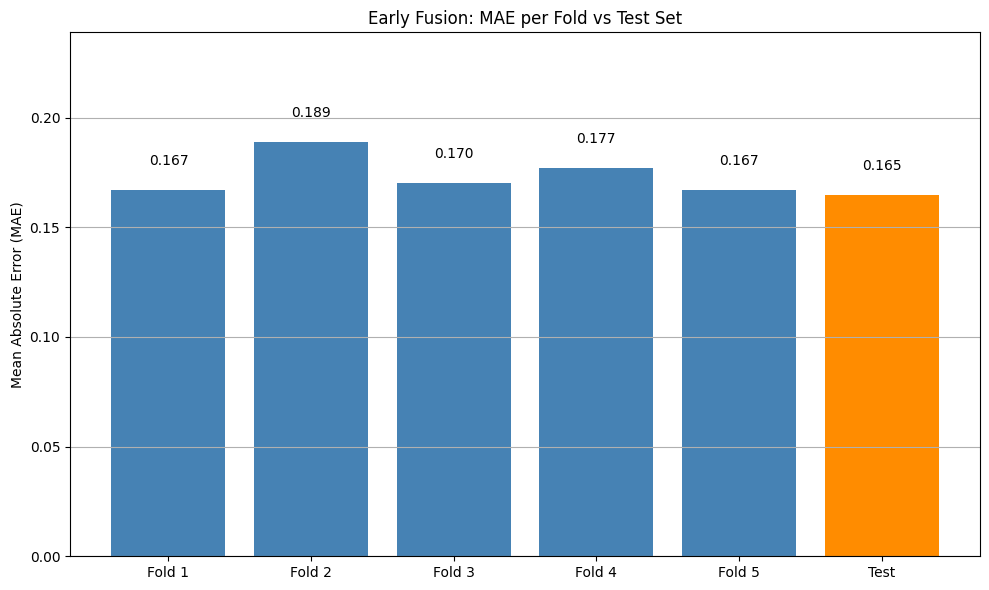

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

# 📊 1. MAE na foldach vs test set
test_mae = mean_absolute_error(y_test, y_pred_test)

plt.figure(figsize=(10, 6))
bars = plt.bar([f"Fold {i+1}" for i in range(len(cv_mae))] + ["Test"],
               cv_mae + [test_mae],
               color=["steelblue"] * len(cv_mae) + ["darkorange"])
plt.title("Early Fusion: MAE per Fold vs Test Set")
plt.ylabel("Mean Absolute Error (MAE)")
plt.ylim(0, max(cv_mae + [test_mae]) + 0.05)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

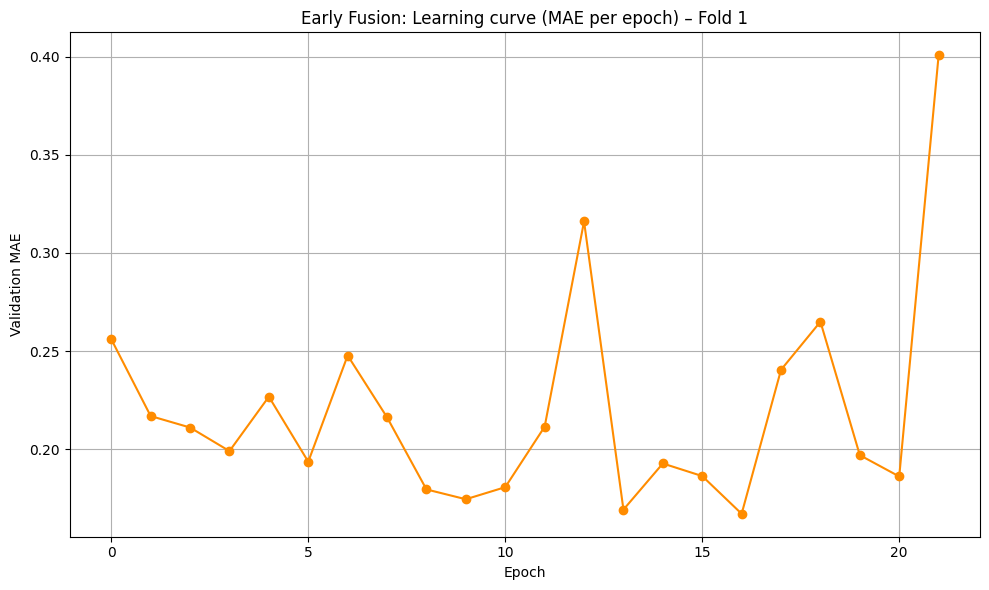

In [9]:
# 📈 2. Learning curve dla Fold 1 (jeśli zapisałeś)
plt.figure(figsize=(10, 6))
plt.plot(mae_fold1, marker='o', color='darkorange')
plt.title("Early Fusion: Learning curve (MAE per epoch) – Fold 1")
plt.xlabel("Epoch")
plt.ylabel("Validation MAE")
plt.grid(True)
plt.tight_layout()
plt.show()

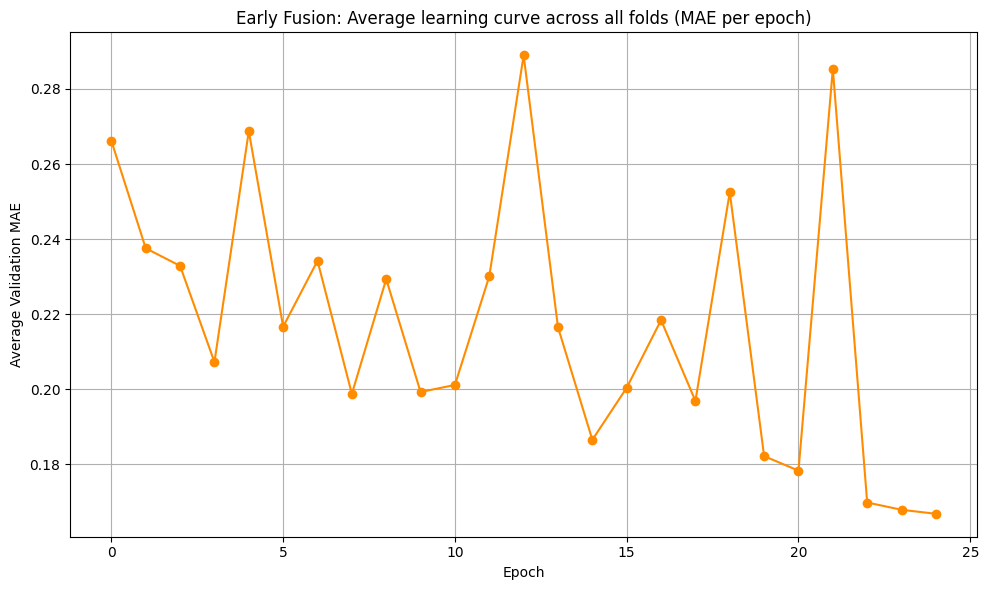

In [10]:
# 📉 3. Średnia krzywa uczenia z 5 foldów
max_epochs = max(len(r) for r in all_mae_curves)
padded = np.full((len(all_mae_curves), max_epochs), np.nan)
for i, r in enumerate(all_mae_curves):
    padded[i, :len(r)] = r
avg_mae = np.nanmean(padded, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(avg_mae, marker='o', color='darkorange')
plt.title("Early Fusion: Average learning curve across all folds (MAE per epoch)")
plt.xlabel("Epoch")
plt.ylabel("Average Validation MAE")
plt.grid(True)
plt.tight_layout()
plt.show()

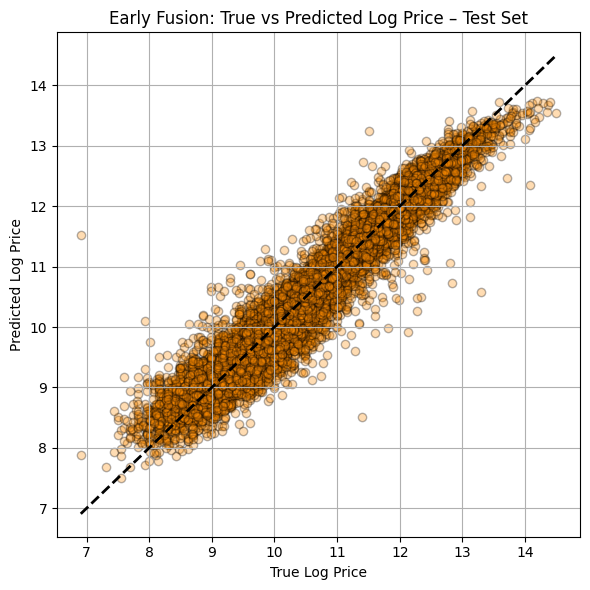

In [11]:
# 🔍 4. Predykcja vs rzeczywistość na zbiorze testowym
plt.figure(figsize=(6, 6))
plt.scatter(
    y_test.values.ravel(),
    y_pred_test.ravel(),
    alpha=0.3,
    color="darkorange",
    edgecolor="k"
)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'k--', lw=2
)
plt.xlabel("True Log Price")
plt.ylabel("Predicted Log Price")
plt.title("Early Fusion: True vs Predicted Log Price – Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()